# Analyzing the Danceability of a Song on Spotify based on its Valence, Energy, Tempo, and Mode
Group 79: Steve (Zefan) Liu, Zeen Lin, Erin Lau, Eric Shuai

<em>Word Count: []</em>

In [1]:
# !!! TABLE OF CONTENTS
# !!! FIGURE (LEAGUE OF) LEGEND

<h2 style="color:#008a05">Introduction</h2>

After three long years of pandemic-styled living, the desire to return to the party-scene has cultivated a spark of excitement in communities worldwide[¹](https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye). To prepare for this upcoming age of buzz and festivities, it is essential for venues, DJ’s, and rising artists to consider the features of their music that increase the likelihood of dancing and fun. However, there are many predictors that can play a role in deciding how danceable a song is. Thus, through this project, our group aims to predict the danceability of an unknown song given two sets of multiple characteristics: one set based off predictors that we believe, having all learnt music theory, would play a role towards danceability (using KNN regression), and another set based off a systematic process using forward selection (using linear regression). We hope to compare the RMSE values of these two sets to decide how well our intuition compares to a systematic choice of selectors.

**Question:** What would the danceability of a song be given its tempo, energy, valence, and mode, and how would this danceability change given a different set of song features?

For this analysis, we will be using the **[Spotify Audio Features dataset](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features)** (<https://www.kaggle.com/datasets/tomigelo/spotify-audio-features>) captured from April 2019 by the user *tomigelo*. This dataset was scraped via Spotify API and Python and consists of variables of audio features (e.g. acousticness, song length, key, etc.) provided by Spotify[²]() pertaining to a given song.

*¹ <https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye>
<br>² <https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features>*

<h2 style="color:#008a05">Method</h2>

For our analysis, we will be comparing two models of danceability: one based off of a K-Nearest Neighbours Regression model using predictors that we believe are related to the danceability of a song, and another based off of a Linear Regression model using forward selection to choose predictors to minimize RMSE for the danceability.

### K-NN Regression Model, the <span style="color:#e61a17">"Intuitive Model"</span>
**<u>Predictors used:</u>**
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

| Predictor                          | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Energy**                         | `energy`        | (dbl, 0.0-1.0, no units)    |
| **Tempo**                          | `tempo`         | (dbl, >= 0, BPM)            |
| **Valence** (musical positiveness) | `valence`       | (dbl, 0.0-1.0, no units)    |
| **Modality**                       | `mode`          | (fct, 0 = minor, 1 = major) |

For our first <span style="color:#e61a17">"intuitive"</span> model, we will perform rectangular k-nearest reighbours regression analysis based on four selectors: the energy, valence, tempo, and mode as predictor variables. Energy and tempo are crucial as they form the rhythmic backbones of a song’s danceability. The valence and mode were selected as a song expressing higher positiveness may influence the listener to dance along, or if the switch of mode can affect the feeling towards a song.

### Linear Regression Model + Forward Selection, the <span style="color:#00bfff">"Systematic Model"</span>
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

Our second, <span style="color:#00bfff">"systematic"</span> model will first have predictors selected from the training data set using the **forward selection** technique, which iterates through predictors until an optimal group of predictors have been selected.

After completing initial cleanup (trimming `N/A` values, selecting, etc.), we first need to proportionally sample the data since the dataset is too large, before splitting it into training/testing data. We then build our <span style="color:#e61a17">"Intuitive Model"</span>, utilising cross-validation to determine an optimal number of neighbours, $k$, before trying our model against testing data to determine model accuracy. Next, we build our <span style="color:#00bfff">"Systematic Model"</span> by performing the forward selection algorithm and using the resulting predictors. Finally, we compare the performance of our two models using our testing set through the RMSE values and plots to see how well our <span style="color:#e61a17">"Intuitive Model"</span> compares to a systematically-designed model.

<h2 style="color:#008a05">Setting up our data</h2>

### Importing Libraries and Loading Data

Begin by setting up all the primary required libraries: `repr`, `tidyverse`, and `tidymodels`. We also load `GGally` so that we can perform `ggpairs()` for data analysis.

In [2]:
# ========== Setting up prerequisites libraries ==========
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)

options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Let's load our data, which was downloaded from Kaggle and now hosted on our project GitHub repository.

In [3]:
# ========== Load the data from the web into R ==========
dataset_url <- "https://github.com/eshuaiii/dsci-100-2022w1-group-79/raw/main/data/SpotifyAudioFeaturesApril2019.csv"

# read the dataset from URL
spotify_big <- read_csv(url(dataset_url))

# read the first 5 rows
head(spotify_big, 5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


### Sampling and Creating Tidy Data

Before we begin sampling our data, we must first address one key concern with our data.
The `tempo` value currently consists of all numbers from 0 (inclusive) onwards. This means that some songs in our dataset would have a tempo of 0, which made us question whether or not a real piece of music could have zero tempo. Through some exploratory analysis, we discovered that the observations that possessed zero tempo were recordings of white noise or podcast-like tracks, or tracks that Spotify was unable to identify, rather than actual music. As these recordings did not align with the goal of our project (that being to support DJ’s and music artists involved in the party scene), we decided to remove all points whose `tempo` = 0 from our analysis.

In [4]:
# ========== Filter for all values whose tempo is not equals to 0 ==========
spotify_big_filtered <- spotify_big |>
    filter(tempo != 0)

Now we can begin sampling our data.
Let's first set our seed to our group number. Then, we sample a portion of our dataset using the `sample_n()` function to ensure an equal split (2079 is an arbitrary number selected simply because it has the number 79 in it). Lastly, as per the [Spotify API docs](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), we change the type of `key`, `mode`, and `time_signature` to categorical variables using the `mutate()` function, and remove `popularity` as it is not a musical feature of a song.

In [5]:
# ========== Setting our seed once ==========
set.seed(79)

# ========== Extract 2079 values using the 
raw_spotify <- spotify_big_filtered |>
    sample_n(2079) |>
    # select all numeric values
    select(acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence) |>
    mutate(key = as.factor(key),
           mode = as.factor(mode),
           time_signature = as.factor(time_signature))
raw_spotify

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
0.897,0.212,150857,0.254,8.37e-01,9,0.1110,-20.003,0,0.0487,140.897,4,0.0398
0.161,0.727,189465,0.704,2.31e-06,7,0.0987,-6.295,0,0.2210,133.913,4,0.3430
0.991,0.451,94000,0.143,9.27e-01,8,0.1070,-25.762,1,0.0740,114.721,4,0.1820
0.840,0.487,240937,0.203,1.80e-02,4,0.1700,-14.686,1,0.0395,127.880,3,0.5050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.1010,0.507,116477,0.804,1.33e-02,1,0.203,-4.986,0,0.2030,152.039,4,0.633
0.0195,0.884,185137,0.590,0.00e+00,8,0.108,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.111,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.123,-2.401,1,0.1060,100.006,4,0.790


Now, let's create our training and testing splits, using (once again) our group number as our proportion value, and `danceability` as our strata argument.

In [6]:
spotify_split <- initial_split(raw_spotify, prop = 0.79, strata = danceability)
spotify_training <- training(spotify_split)
spotify_testing <- testing(spotify_split)

spotify_training

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
8.97e-01,0.212,150857,0.254,0.8370,9,0.111,-20.003,0,0.0487,140.897,4,0.0398
9.91e-01,0.451,94000,0.143,0.9270,8,0.107,-25.762,1,0.0740,114.721,4,0.1820
1.82e-05,0.449,167226,0.973,0.0581,4,0.374,-3.786,1,0.0837,155.023,4,0.7190
9.15e-01,0.409,182107,0.253,0.0278,3,0.104,-9.880,0,0.0363,114.023,3,0.2180
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.0198,0.788,139050,0.509,2.14e-02,6,0.0976,-8.763,1,0.1630,154.960,4,0.887
0.0195,0.884,185137,0.590,0.00e+00,8,0.1080,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.1110,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.1230,-2.401,1,0.1060,100.006,4,0.790


We now create an unscaled dataframe with the predictors that we hope to look at in the <span style="color:#e61a17">"Intuitive Model"</span>.

In [7]:
# ========== Dataframe with our intuitive data ==========
# first, select all the predictors we're interested in (danceability, energy,tempo, valence, mode)
# Then transform mode into a factor.

spotify_training_intuitive_unscaled <- spotify_training |>
    select(danceability, energy, tempo, valence) |>
    mutate(energy = as.numeric(energy),
           tempo = as.numeric(tempo),
           valence = as.numeric(valence))
head(spotify_training_intuitive_unscaled, 5)

danceability,energy,tempo,valence
<dbl>,<dbl>,<dbl>,<dbl>
0.212,0.254,140.897,0.0398
0.451,0.143,114.721,0.1820
0.449,0.973,155.023,0.7190
0.409,0.253,114.023,0.2180
0.417,0.733,141.536,0.7250


<h2 style="color:#008a05">Preliminary Exploratory Data Analysis</h2>

Let's first take a look at all our data and how they correspond to each other! For sake of simplicity, let's only look at all continuous variables (i.e. no factors)

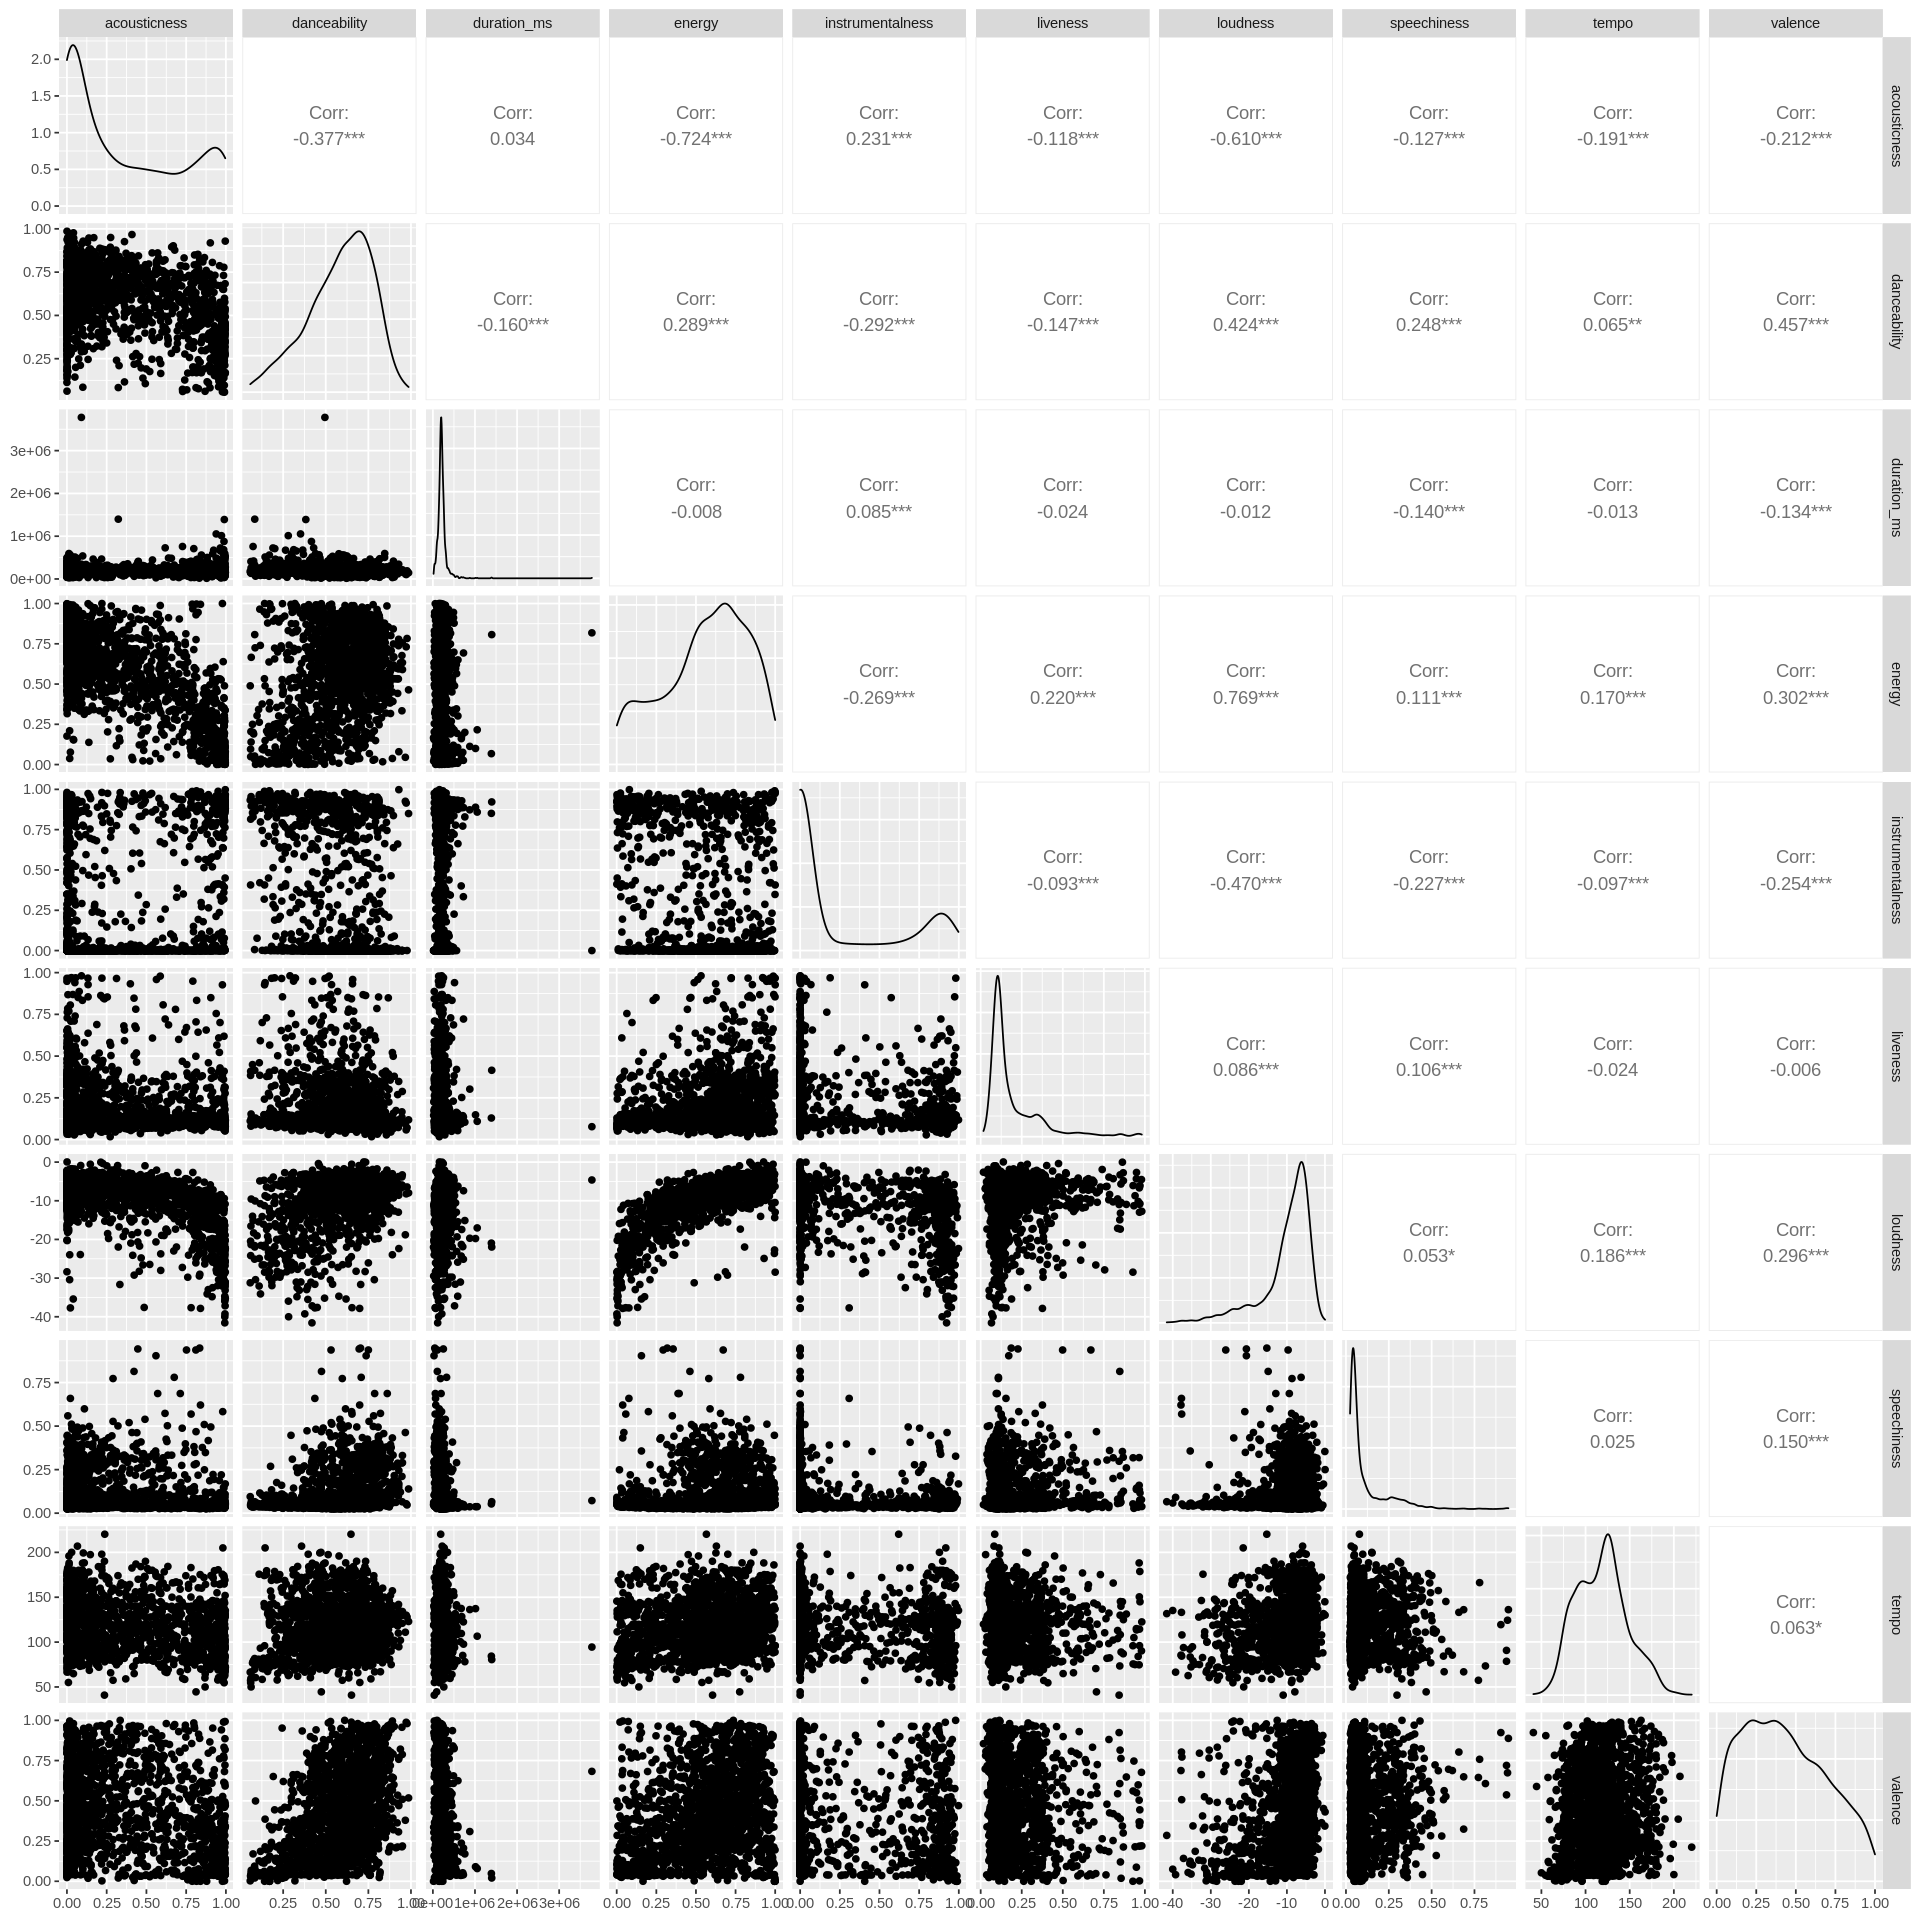

In [8]:
# ========== Create a plot with all variables against danceability ==========
options(repr.plot.width = 16, repr.plot.height = 16) 
pairsplot <- ggpairs(spotify_training |>
                        select(-key, -mode, -time_signature))
pairsplot

# some broken code
# source: https://www.datanovia.com/en/blog/how-to-plot-one-variable-against-multiple-others/
# explore_plot <- spotify_training |>
#     select(-key, -mode, -time_signature) |>
#     gather(key = "variable", value = "value",
#            -danceability) |>
#     ggplot(aes(x = value, y = danceability)) +
#         geom_point() +
#         facet_wrap(~variable, scales = "free")
# explore_plot

### <span style="color:#e61a17">Intuitive Model</span>

First, let's take a look at the statistical summary of our variables.

In [9]:
# # ========== A statistical summary of our Intuitive Model predictors ==========
spotify_training_intuitive_summary <- spotify_training_intuitive_unscaled |>
                            summarize(number_of_observations = n(),
                                      mean_danceability = mean(danceability),
                                      mean_energy = mean(energy),
                                      mean_tempo = mean(tempo),
                                      mean_valence = mean(valence),
                                      sd_danceability = sd(danceability),
                                      sd_energy = sd(energy),
                                      sd_tempo = sd(tempo),
                                      sd_valence = sd(valence))
spotify_training_intuitive_summary

number_of_observations,mean_danceability,mean_energy,mean_tempo,mean_valence,sd_danceability,sd_energy,sd_tempo,sd_valence
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1639,0.5846792,0.5659,118.346,0.4284079,0.1868775,0.2616224,28.50608,0.2604727


From here, we can see that we have a generally equal danceability mean of around 0.58. The average song BPM revolves around 120 BPM. The means and standard deviations are rather balanced, an indication of well-split data.

Next, let's plot each variable against `danceability`, separating by `mode`.

In [10]:
# !!! IGNORE UNTIL CERTAIN OF SCALING FOR PLOTS. Scale and Center in recipe instead.
# ========== Scale and centre our Intuitive Data This dataframe will be used for our analysis! ==========

# spotify_training_intuitive <- spotify_training |>
#     select(danceability, energy, tempo, valence, mode) |>
#     mutate(energy = as.numeric(scale(energy, center = TRUE, scale = TRUE)),
#            tempo = as.numeric(scale(tempo, center = TRUE, scale = TRUE)),
#            valence = as.numeric(scale(valence, center = TRUE, scale = TRUE)),
#            mode = as_factor(mode))
# head(spotify_training_intuitive, 5)

In [11]:
# ========== General Visualizations for Intuitive Model predictors ==========
options(repr.plot.width = 15, repr.plot.height = 8)

# Visualize the relationship between danceability and energy, classified by mode
ggplot(spotify_training_intuitive_unscaled, aes(x = energy, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap() +
    labs(x = "The energy of song (no units)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set2")

# Visualize the relationship between danceability and valence, classified by mode
ggplot(spotify_training_intuitive_unscaled, aes(x = valence, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap() +
    labs(x = "The valence of song (no units)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set1")

# Visualize the relationship between danceability and tempo, classified by mode
ggplot(spotify_training_intuitive_unscaled, aes(x = tempo, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap() +
    labs(x = "The tempo of song (no units)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Dark2")

ERROR: Error in wrap_as_facets_list(facets): argument "facets" is missing, with no default


Although we are working with a lot of data and hence are prone to overplotting in these visualizations, the general trend outlined by the `geom_smooth()` line is noticeable for the energy and valence of a song. For tempo, the trend is discernable, but not quite as obvious.

### <span style="color:#00bfff">Systematic Model</span>

In [ ]:
# This section is up to you, Steve! You got this :)

In [ ]:
# (info) Uncomment if comparing "best correlated" predictors
## --- Code to make the dataframe ---
# spotify_training_correlated <- spotify_training |>
#                 select(danceability, acousticness, instrumentalness, loudness, valence) |>
#                 mutate(acousticness = as.numeric(scale(acousticness, center = TRUE, scale = TRUE)),
#                        instrumentalness = as.numeric(scale(instrumentalness, center = TRUE, scale = TRUE)),
#                        loudness = as.numeric(scale(loudness, center = TRUE, scale = TRUE)),
#                        valence = as.numeric(scale(valence, center = TRUE, scale = TRUE)))
# head(spotify_training_correlated, 5)
## -- Code to run ggpairs ---
# spotify_training_test <- spotify_training |>
#     select(danceability, acousticness, instrumentalness, loudness, valence) |>
#     ggpairs()
# spotify_training_test

<h2 style="color:#008a05">Data Analysis</h2>

### <span style="color:#e61a17">Intuitive Model</span>

In [ ]:
# This part is all yours, Zeen! :D
# I fixed the code to use the right data frames but as of right now it's broken because we have mode :(
# we'll have to fix that later!

In [11]:
# Perform k-nn regression algorithm
# create spec + tune()
spotify_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("regression")

# create recipe
spotify_recipe <- recipe(danceability ~ ., data = spotify_training_intuitive_unscaled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# perform cross-validation
spotify_vfold <- vfold_cv(spotify_training_intuitive_unscaled, v = 5, strata = danceability)
spotify_workflow <- workflow() |>
    add_recipe(spotify_recipe) |>
    add_model(spotify_spec)
spotify_workflow

# create workflow + gridvals <- tibble(neighbors = seq(1, 400))
gridvals <- tibble(neighbors = seq(1, 200))
spotify_results <- spotify_workflow |>
    tune_grid(resamples = spotify_vfold, grid = gridvals) |>
    collect_metrics()
spotify_results

# output results + pick out best result as k_min
spotify_min <- spotify_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice(1)
spotify_min 

# k_min <- spotify_min |> 
#     pull(neighbors)

# # retrain everything + find rmse
# spotify_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# spotify_best_fit <- workflow() |>
#     add_recipe(spotify_recipe) |>
#     add_model(spotify_best_spec) |>
#     fit(data = spotify_training_intuitive_unscaled)

# spotify_summary <- spotify_best_fit |>
#     predict(spotify_testing_cleaned) |>
#     bind_cols(spotify_testing_cleaned) |>
#     metrics(truth = danceability, estimate = .pred)
# spotify_summary

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.2009303,5,0.002522923,Preprocessor1_Model001
1,rsq,standard,0.1658383,5,0.012410122,Preprocessor1_Model001
2,rmse,standard,0.1756991,5,0.001575655,Preprocessor1_Model002
2,rsq,standard,0.2318043,5,0.010892456,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rmse,standard,0.1583008,5,0.001426734,Preprocessor1_Model199
199,rsq,standard,0.3368101,5,0.016571177,Preprocessor1_Model199
200,rmse,standard,0.1583545,5,0.001428636,Preprocessor1_Model200
200,rsq,standard,0.3363396,5,0.016512562,Preprocessor1_Model200


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
51,rmse,standard,0.1491542,5,0.001111924,Preprocessor1_Model051


In [12]:
spotify_min <- spotify_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice(1)
spotify_min 

k_min <- spotify_min |> 
    pull(neighbors)
    # retrain everything + find rmse
spotify_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

spotify_best_fit <- workflow() |>
    add_recipe(spotify_recipe) |>
    add_model(spotify_best_spec) |>
    fit(data = spotify_training_intuitive_unscaled)

spotify_testing_cleaned <- spotify_testing |>
    select(danceability, energy, valence, tempo)

spotify_summary <- spotify_best_fit |>
    predict(spotify_testing_cleaned) |>
    bind_cols(spotify_testing_cleaned) |>
    metrics(truth = danceability, estimate = .pred)
spotify_summary

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
51,rmse,standard,0.1491542,5,0.001111924,Preprocessor1_Model051


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1417535
rsq,standard,0.4507596
mae,standard,0.1133621


### <span style="color:#00bfff">Systematic Model</span>

<h2 style="color:#008a05">Results and Discussion</h2>

We expect that an appropriate model will be developed to incorporate our predictor variables—valence, mode, tempo, and energy—to predict the danceability of an unknown song. The results of this study could assist musicians who desire to create danceable music according to specific characteristics. This finding could assist them in identifying and selecting danceable features of the song before creating it, thus increasing the likelihood of a successful composition.

Further, this study raises several interesting questions. For instance:
- How do other variables, like a song’s length, its key, or how wordy it is, affect its danceability?
- Is popularity based primarily on how danceable a song is?
- Since the danceability variable, per Spotify, is a combination of factors like beat strength, regularity, and stability, is it an unbiased, objective variable?
- Could the danceability of a song be viewed differently across regions, cultures, and societies?

<br><br><br>
*Thank you! - Group 79*